<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/research_ReadyPlayer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

方針: TextCNNを用いて各スコアに対してクラス分類を行う <br>
(具体的な方法) <br>
レビュー（評価）文章に対するスコアを学習させる <br>
スコアは0.1刻みの離散値のためクラス分類を行う <br>
今回はスコアを四捨五入して整数にして行う <br> 
よって5クラスのスコアに対する各レビューのクラス分類とする

In [1]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303

In [2]:
import numpy as np
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
random_state = 42

cuda


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns

path = "/content/drive/My Drive/movie_research/review_csv/SF_data.csv"
data = pd.read_csv(path) 

data = data[data["title"] == "レディ・プレイヤー1|Ready Player One"]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


デモとしてレディ・プレイヤー1のデータについて分析を行う
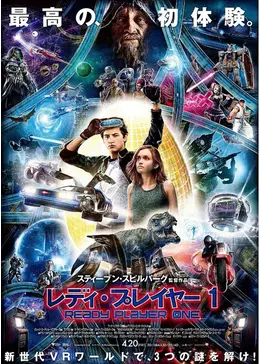

この映画めちゃおもろい



In [4]:
#non_score = data[data["score"] == '-']
#data = data[data["score"] != '-']

In [5]:
print('{}件のデータを扱う'.format(len(data)))

18880件のデータを扱う


#前処理とデータ可視化

In [6]:
#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].replace('-','0') #回答してない人を0埋め
  df[col] = df[col].astype(float)

  return df

data = prepro(data, "score")

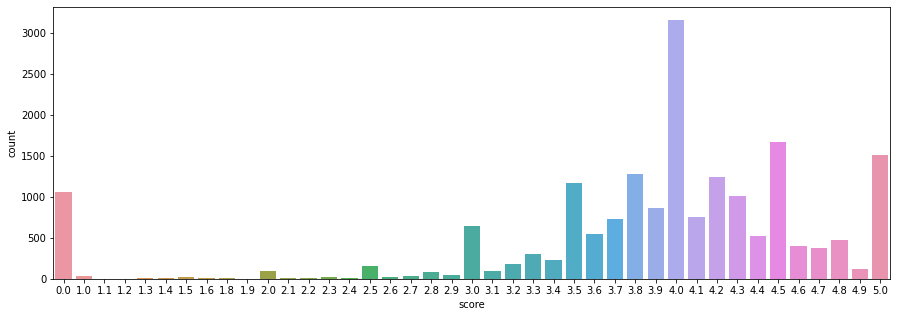

In [7]:
plt.figure(figsize=(15, 5))
sns.countplot(data["score"].sort_values())

In [8]:
#score(1,2,3,4,5)の5クラス分類にする
data["score"] = data["score"].round().astype(int)

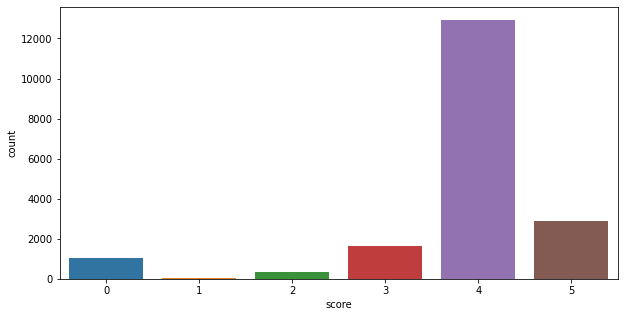

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(data["score"].sort_values())

レディ・プレイヤー1:
評価が全体的に高い傾向にあるデータを扱うことになりそう



In [10]:
data["time"] = pd.to_datetime(data["time"])

In [11]:
data["time"].sample(3)

419655   2018-05-03 23:44:00
427593   2019-02-09 20:33:00
422836   2020-06-02 10:44:00
Name: time, dtype: datetime64[ns]

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 <a list of 7 Text major ticklabel objects>)

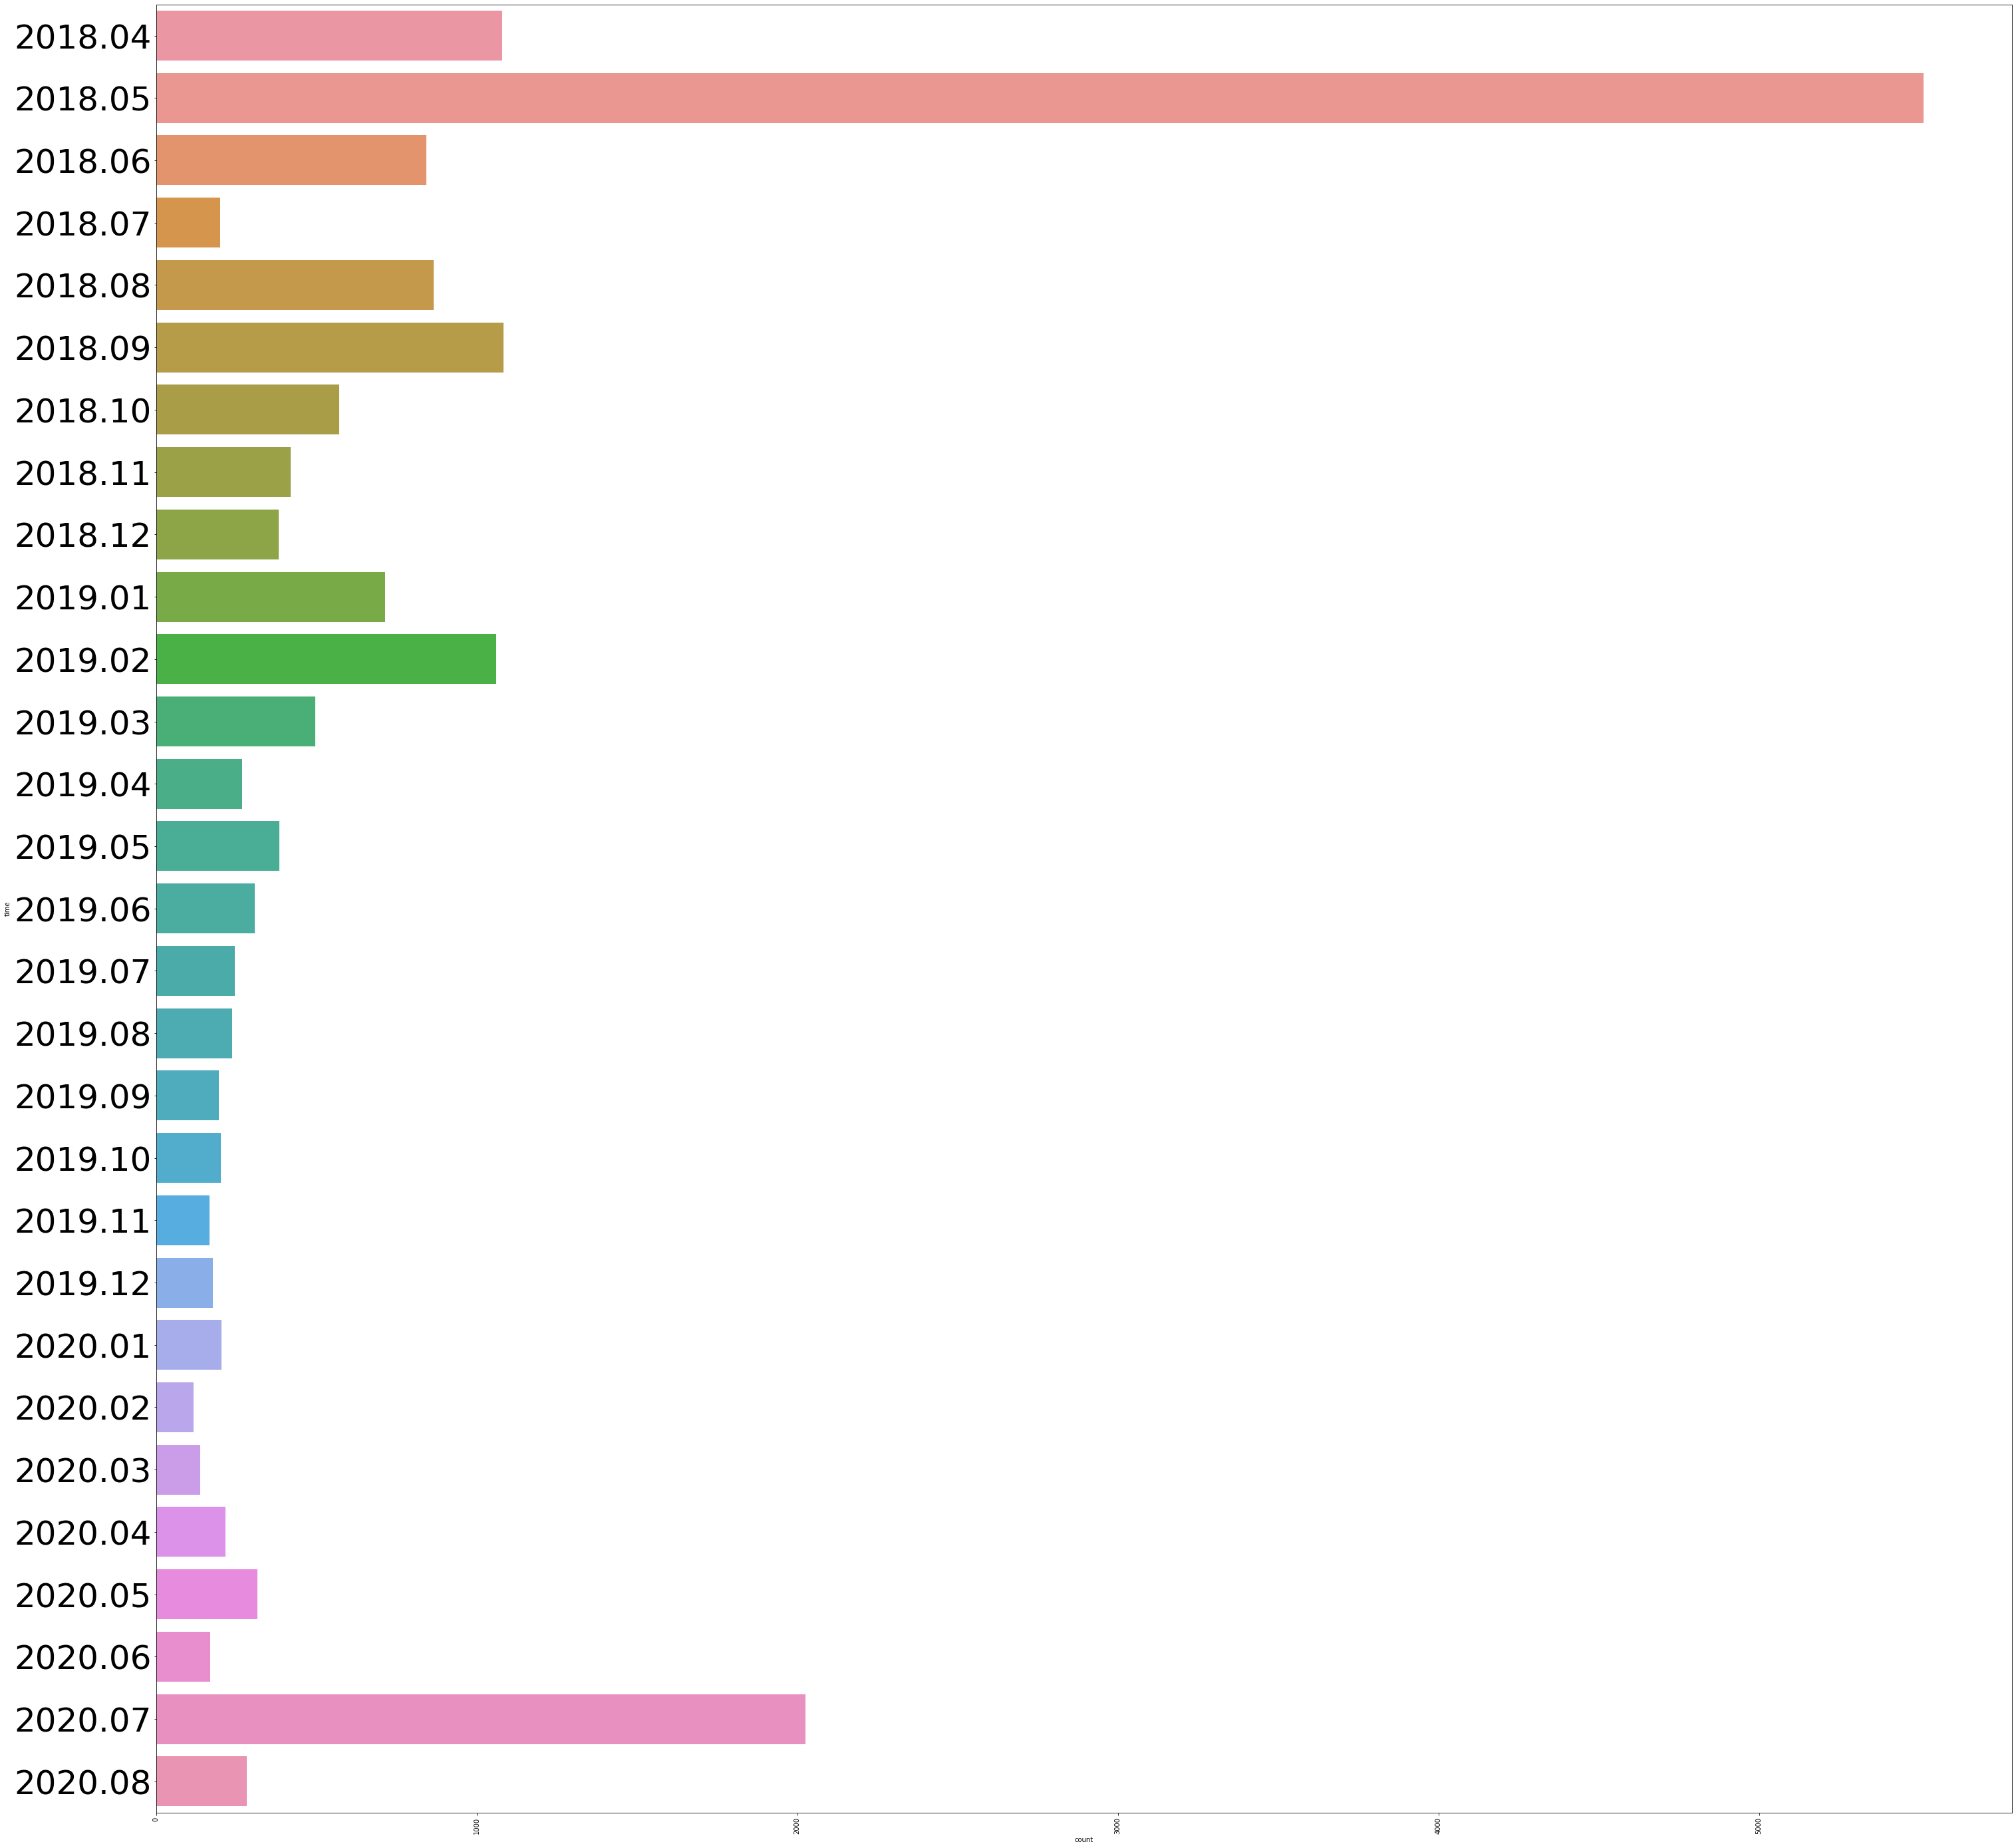

In [12]:
plt.figure(figsize=(50, 50))
sns.countplot(y=data["time"].dt.strftime('%Y.%m') )
plt.yticks(fontsize=50) #y軸のメモリサイズの拡大
plt.xticks(rotation=90) #x軸ラベルを縦に表示 

公開日が2018年4月20日のため，その翌月にコメント数が伸びている <br> 
DVD発売が2018年8月22日だったため同年9月にコメント数が若干伸びている <br> 
2019年1月に第91回アカデミー賞を受賞してまた視聴数が伸びたのだと考えられそう <br> 
2020.7月に再度コメント数が伸びているのは金曜ロードショーで放映されたからと考えられそう <br> 


In [13]:
import neologdn 
import string 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 

  #数字をすべて0に置換 
  #text = re.sub(r'\d+', '0', text)

  #string.punctuationの除去
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table) 

  text = text.replace("｡",'')
  text = text.replace("。",'')
  text = text.replace("，",'')
  text = text.replace(",",'')
  text = text.replace("、",'')
  text = text.replace("､",'')
  text = text.replace("…",'')
  text = text.replace("･",'')
  
  #空白を除去
  text = re.sub(r' ','', text)
  text = re.sub(r'　','', text)
  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()
  #改行コードの除去
  text = text.replace('\n', '')

  return text 

In [14]:
!pip install emoji 
!pip install nagisa 
#!pip install unicodedata 

import emoji
import nagisa

def delete_emoji(text):
  target_list = [w for w in text if w in emoji.UNICODE_EMOJI]
  for trg in target_list:
    text = text.replace(trg, "")
  return text 

In [15]:
data["review"] = data["review"].apply(text_preprocess) 

In [16]:
data["review"]

412299       面白かったさくっと観れる世界観もかなり面白い未来はこんな世界あってもおかしくないよなと思った
412300    ﾃﾚﾋﾞで観ました色んな映画や昔の音楽を彷彿とさせるような新しくて懐かしい映画家族とこれはあ...
412301    観ていて楽しかったｼｬｲﾆﾝｸﾞは観れていないけど色々ｷｬﾗｸﾀｰも出てきてｻﾌﾞｶﾙﾁｬｰ...
412302                    ｽﾋﾟﾙﾊﾞｰｸﾞ監督の中で1番好きな映画観てて飽きない内容もいい
412303    ｹﾞｰﾑに没頭していた時を思い出しましたｷｬﾗの渋滞が過ぎます笑特にｼｬｲﾆﾝｸﾞの再現度が...
                                ...                        
431174    普段sfを見ない分よく感じた昔のsfしかわからなかったが色んな映画を見ていればより楽しめる作...
431175    ｹﾞｰﾑも好きで映画も好きなら小ﾈﾀ満載で楽しめるただ小ﾈﾀ多すぎる観直そうとはあまり思えな...
431176    めっっっちゃ面白かった好きだいとｰがｲｹﾒﾝほんと顔が好き仕草も好きかっこいい何も考えずに派...
431177    ｽﾋﾟﾙﾊﾞｰｸﾞありがとうという感想を以前見かけたけど鑑賞後その気持ちがすごく分かったあの...
431178    映画後半はｽﾋﾟﾙﾊﾞｰｸﾞへの感謝の気持ちで涙が溢れそうになったｶﾞﾝﾀﾞﾑｼｬｷｰﾝの登...
Name: review, Length: 18880, dtype: object

In [17]:
data["review"] = data["review"].apply(delete_emoji)

In [18]:
data[data["name"] == "ひとぴーの感想・評価"]["review"].values

array(['616観たあ楽しかったぁ最初から凄い世界だｺｲﾝ集めたりwｺﾞｰﾙするのとか面白い️ｹﾞｰﾑは全然しないけど観てるの好きだから️ﾀｲｼｪﾘﾀﾞﾝってmudの子だったのかそれとｿﾞﾝﾋﾞｰﾜｰﾙﾄﾞのいろんな沢山の映画名やｼｰﾝを言ったりしてﾜｸﾜｸが止まらないもっともっと沢山映画が観たくなるこれまで色々な映画を観てて良かったｽﾃｨｰｳﾞﾝｷﾝｸﾞが気に入ってる方のｼｬｲﾆﾝｸﾞしか観てないんだよなぁ買って持ってるんだけどこれは観るしかないな笑今回は森崎ｳｨﾝが出てるから字幕で観た英語上手だね今度は吹き替えでも観たいなｽﾋﾟﾙﾊﾞｰｸﾞ凄いなぁこんなの作っちゃってまさかのｶﾞﾝﾀﾞﾑまで日本好きなんですね笑終盤に向けての闘いにはどれほどのｷｬﾗを出してくれてるのか観ててﾜｸﾜｸしっぱなしだったﾁｬｯｷｰの発想凄いなwwwｱｲｱﾝｼﾞｬｲｱﾝﾄは観てて良かったぁ️ふぅいっぱいいっぱい楽しかったぁそして2回目75に今度は吹き替えで観たよぉ古い方のｼｬｲﾆﾝｸﾞとｻﾀﾃﾞｰﾅｲﾄﾌｨｰﾊﾞｰ観てからwwｼｬｲﾆﾝｸﾞは観て良かった面白さ倍増だったあとｱﾚにｷﾃｨちゃんのｽﾃｯｶｰで可愛らしさを演出してたね️芸が細かい笑2回目の方がより楽しめた今度は家事しながらの時にでも又流し観でもしようかなぁそれほど観られるwwwﾚﾃﾞｨﾌﾟﾚｰﾔｰ1最高私の後悔hddﾔﾊﾞくてﾊﾞｶﾙｰとかﾌﾞﾚｯｸﾌｧｽﾄ他大量に今は観ないかなｰって前に映画を削除しちまったんだよなぁｰあｰ後悔wwもっともっと映画観たい笑'],
      dtype=object)

In [19]:
import MeCab 

def tokenize_mecab(sentence):
    """日本語の文を形態素の列に分割する関数

    :param sentence: str, 日本語の文
    :return tokenized_sentence: list of str, 形態素のリスト
    """
    tagger = MeCab.Tagger()
    node = tagger.parse(sentence)
    node = node.split("\n")
    tokenized_sentence = []
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            # 文が終わったら終了
            break
        # 分割された形態素を追加
        tokenized_sentence.append(feature[0])
    return " ".join(tokenized_sentence)

In [20]:
data["review_tokenize"] = data["review"].apply(tokenize_mecab)

In [21]:
data["length"] = data["review_tokenize"].apply(lambda x: len(x.split(' ')))

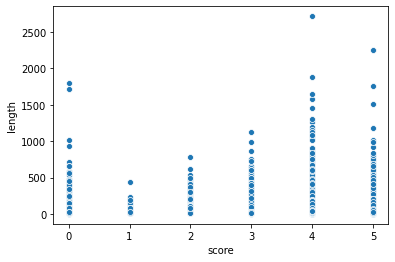

In [22]:
import seaborn as sns 
sns.scatterplot(x=data["score"].sort_values(),y=data["length"])

In [23]:
data["length"].max()

2717

#TextCNNを用いてクラス分類を行う

##辞書の構築

In [24]:
class Vocab(object):
  def __init__(self, word2id={}):
    self.word2id = dict(word2id)
    self.id2word = {v: k for k, v in self.word2id.items()}
  
  def build_vocab(self, sentences, min_count=1):
    """
    コーパスから語彙の辞書を構築するメソッド

    :param sentences: list of list of str, コーパス
    :param min_count: int, 辞書に含める単語の最小出現回数
    """
    word_counter = {}
    for sentence in sentences:
      for word in sentence:
        # dict.get(key, 0)はdictにdict[key],なければ0を返す
        word_counter[word] = word_counter.get(word, 0) + 1
    
    #min_count回以上出現する単語を加える
    for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
      if count < min_count : 
        break 
      _id = len(self.word2id)
      self.word2id.setdefault(word, _id)
      self.id2word[_id] = word 
    
    #語彙に含まれる単語の出現回数を保持する
    #self.raw_vocab = {w: word_counter[w] for w in self.word2id.keys() if w in word_counter }


In [25]:
"""
# 特殊なトークンは事前に定義しておく
PAD_TOKEN = '<PAD>'  # バッチ処理の際に、短い系列の末尾を埋めるために使う （Padding）
BOS_TOKEN = '<S>'  # 系列の始まりを表す （Beggining of sentence）
EOS_TOKEN = '</S>'  # 系列の終わりを表す （End of sentence）
UNK_TOKEN = '<UNK>'  # 語彙に存在しない単語を表す （Unknown）
PAD = 0
BOS = 1
EOS = 2
UNK = 3

MIN_COUNT = 1  # 語彙に含める単語の最低出現回数

# 単語をIDに変換する辞書の初期値を設定
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab = Vocab(word2id=word2id)
vocab.build_vocab(data["review_tokenize"].values.tolist(), min_count=MIN_COUNT)
print("語彙数:", len(vocab.word2id))

"""

'\n# 特殊なトークンは事前に定義しておく\nPAD_TOKEN = \'<PAD>\'  # バッチ処理の際に、短い系列の末尾を埋めるために使う （Padding）\nBOS_TOKEN = \'<S>\'  # 系列の始まりを表す （Beggining of sentence）\nEOS_TOKEN = \'</S>\'  # 系列の終わりを表す （End of sentence）\nUNK_TOKEN = \'<UNK>\'  # 語彙に存在しない単語を表す （Unknown）\nPAD = 0\nBOS = 1\nEOS = 2\nUNK = 3\n\nMIN_COUNT = 1  # 語彙に含める単語の最低出現回数\n\n# 単語をIDに変換する辞書の初期値を設定\nword2id = {\n    PAD_TOKEN: PAD,\n    BOS_TOKEN: BOS,\n    EOS_TOKEN: EOS,\n    UNK_TOKEN: UNK,\n    }\n\nvocab = Vocab(word2id=word2id)\nvocab.build_vocab(data["review_tokenize"].values.tolist(), min_count=MIN_COUNT)\nprint("語彙数:", len(vocab.word2id))\n\n'

##単語のID化

In [26]:
def sentence_to_ids(vocab, sen):
  """
  単語のリストをIDのリストに変換する関数
  :param vocab: class Vocab object
  :param sen : list of str, 文を分かち書きして得られた単語のリスト
  """
  #辞書にない言葉にUNKを割り当てる
  out = [vocab.word2id.get(word, UNK) for word in sen ]
  return out 

#日本語のテキストを単語IDに変換する
#id_text = [sentence_to_ids(vocab, sen) for sen in data["review_tokenize"].values.tolist()]

In [27]:
#print(data["review_tokenize"].values.tolist()[1])
#print(id_text[1])

#DataLoaderの定義

In [28]:
class DataLoader(object):
  def __init__(self, X, Y, batch_size, shuffle=True):
    """
    :param X: list, 入力言語の文章のリスト (単語IDのリスト)
    :param Y: list, 出力言語の文章のリスト (単語IDのリスト)
    :param batch_size: int, バッチサイズ
    :param shuffle: bool, サンプルをシャッフルするかどうか
    """
    self.data = list(zip(X, Y))
    self.batch_size = batch_size 
    self.shuffle = shuffle 
    self.start_index = 0 
    self.reset() 

  def reset(self):
    if self.shuffle:
      self.data = shuffle(self.data, random_state=random_state)
    self.start_index = 0 

  def __iter__(self):
    return self 

  def __next__(self):

  #ポインタが最後まで到達したら初期化する
    if self.start_index >= len(self.data): 
      self.reset() 
      raise StopIteration() 

    #バッチを取得
    X, Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
    #短い系列の末尾をパディングする
    lengths_X = [len(s) for s in X]
    max_length_X = max(lengths_X) 
    padded_X = [self.pad_seq(s, max_length_X) for s in X] 
    #tensorに変換
    batch_X = torch.tensor(padded_X, dtype=torch.long, device=device)
    batch_Y = torch.tensor(Y, dtype=torch.long, device=device)

    #ポインタを更新する
    self.start_index += self.batch_size 

    return batch_X, batch_Y 
  
  @staticmethod 
  def pad_seq(seq, max_length):
    """
    系列の末尾をパディングする 
    :param seq: list or int, 単語のインデックスのリスト
    :param seq: max_length: int, バッチ内の系列の最大長
    :return seq: list of int, 単語のインデックスのリスト
    """
    seq += [PAD for i in range(max_length - len(seq))]
    return seq 

#モデルの定義

In [29]:
class TextCNN(nn.Module):

  def __init__(self, vocab_size, embedding_size, class_num, kernel_num, kernel_sizes, dropout, static):
    """
     :param vocab_size: int, 入力言語の語彙数
     :param embedding_size: int, 埋め込みベクトルの次元数
     :param class_num: int, 出力のクラス数
     :param kernel_num: int,　畳み込み層の出力チャネル数
     :param kernel_sizes: list of int, カーネルのウィンドウサイズ
     :param dropout: float, ドロップアウト率
     :param static: bool, 埋め込みを固定するか否かのフラグ
    
    """
    super(TextCNN, self).__init__()
    self.static = static 
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    # nn.ModuleList: 任意の数のModuleをlistのような形で保持することができるクラス
    self.convs = nn.ModuleList(
        [nn.Conv1d(1, kernel_num, (kernel_size, embedding_size)) for kernel_size in kernel_sizes]
    )
    self.dropout = nn.Dropout(dropout) 
    self.out = nn.Linear(len(kernel_sizes)*kernel_num, class_num)

  def forward(self, x):
    # x: (batch_size, max_length) 
    x = self.embedding(x) #(batch_size, max_length, embedding_size)

    if self.static:
      x = torch.tensor(x) #埋め込みを固定

    # (batch_size, 1, max_length, embedding_size)
    x = x.unsqueeze(1) 
    # [(batch_size, kernel_num, max_length-kernel_size+1), ...]*len(kernel_sizes)
    x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] 
    # [(batch_size, kernel_num), ...]*len(kernel_sizes)
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
    # [(batch_size, len(kernel_sizes)*kernel_num)]
    x = torch.cat(x, 1)
    x = self.dropout(x) 

    logit = self.out(x) 
    return logit 

#学習

In [39]:
"""
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
  # バッチの損失を計算
  model.train(is_train)

  if is_train: 
    optimizer.zero_grad() 
  
  pred_Y = model(batch_X)

  loss = criterion(pred_Y.long(), batch_Y.long())

  pred = torch.max(pred_Y, 1)[1].view(batch_Y.size())
  n_correct = (pred.data == batch_Y.data).sum() 

  if is_train:
    loss.backward() 
    optimizer.step() 

  return loss.item(), n_correct.item() 

"""

In [40]:
data.head(2)

,title,name,time,review,score,URL,review_tokenize,length
412299,レディ・プレイヤー1|Ready Player One,あおの感想・評価,2020-08-28 16:20:00,面白かったさくっと観れる世界観もかなり面白い未来はこんな世界あってもおかしくないよなと思った,4,https://filmarks.com//movies/63747?page=1,面白かっ た さくっ と 観れる 世界 観 も かなり 面白い 未来 は こんな 世界 あっ...,24
412300,レディ・プレイヤー1|Ready Player One,りほこの感想・評価,2020-08-27 23:27:00,ﾃﾚﾋﾞで観ました色んな映画や昔の音楽を彷彿とさせるような新しくて懐かしい映画家族とこれはあ...,4,https://filmarks.com//movies/63747?page=1,ﾃﾚﾋﾞ で 観 まし た 色んな 映画 や 昔 の 音楽 を 彷彿 と さ せる よう な...,44


In [41]:
data["score"].value_counts() 

4    12926
5     2882
3     1632
2      343
1       43
Name: score, dtype: int64

In [42]:
#訓練データと検証データの作成
#交差検証は行わずtrain:valid=7:3にして評価を行うとする
from sklearn.model_selection import train_test_split 

non_score = data[data["score"] == 0.0] 
data = data[data["score"] != 0.0]

X = data["review_tokenize"]
y = data['score']-1

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3,shuffle=True,random_state=42)

test_X = non_score["review_tokenize"]

#del data, non_score

In [59]:
y.value_counts() 

3    12926
4     2882
2     1632
1      343
0       43
Name: score, dtype: int64

In [43]:
# 特殊なトークンは事前に定義しておく
PAD = 0
UNK = 1
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

MIN_COUNT = 1  # 語彙に含める単語の最低出現回数

# 単語をIDに変換する辞書の初期値を設定
word2id = {
    PAD_TOKEN: PAD,
    UNK_TOKEN: UNK,
    }

#訓練データで辞書を構築する
vocab = Vocab(word2id=word2id)
vocab.build_vocab(train_X.values.tolist(), min_count=MIN_COUNT)
print("語彙数:", len(vocab.word2id))

model_args = {
    'vocab_size': len(vocab.id2word),
    'embedding_size': 128,
    'class_num': 5,
    'kernel_num': 64, 
    'kernel_sizes': [3,4,5],
    'dropout': 0.5, 
    'static': False, 
}

lr = 0.001 
num_epochs = 30 
batch_size = 128 
ckpt_path = 'cnn.pth'

語彙数: 2732


In [44]:
#各データをid化
train_X = [sentence_to_ids(vocab, x) for x in train_X]
valid_X = [sentence_to_ids(vocab, x) for x in valid_X]
test_X = [sentence_to_ids(vocab, x) for x in test_X]

In [45]:
#model 
model = TextCNN(**model_args)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_X, train_y, batch_size)
valid_dataloader = DataLoader(valid_X, valid_y, batch_size)

In [49]:
from torch.autograd import Variable #自動微分用

best_valid_acc = 0

for epoch in range(1, num_epochs+1):
  train_losses = []
  train_corrects = 0
  valid_losses = []
  valid_corrects = 0 
  #train 
  for batch in train_dataloader:
    batch_X, batch_Y = batch 
    batch_X, batch_Y = Variable(batch_X), Variable(batch_Y)
    #train_loss, train_correct = compute_loss(
    #    batch_X, batch_Y, model, criterion, optimizer, is_train=True
    #)
    optimizer.zero_grad()
    outputs = model(batch_X).float()
    #print(outputs.shape)
    #print(labels.shape)
    #loss = criterion(torch.sigmoid(outputs), labels)
    loss = criterion(outputs, batch_Y)
    loss.backward()
    optimizer.step()

    pred = torch.max(outputs, 1)[1].view(batch_Y.size())
    n_correct = (pred.data == batch_Y.data).sum()
    train_correct = n_correct.item()  

    train_losses.append(loss.item())
    train_corrects += train_correct 
  #valid 
  for batch in valid_dataloader:
    batch_X, batch_Y = batch
    batch_X, batch_Y = Variable(batch_X), Variable(batch_Y) 
    #valid_loss, valid_correct = compute_loss(
    #    batch_X, batch_Y, model, criterion, is_train=False
    #)
    optimizer.zero_grad()
    outputs = model(batch_X).float()
    valid_loss = criterion(outputs, batch_Y)

    pred = torch.max(outputs, 1)[1].view(batch_Y.size())
    n_correct = (pred.data == batch_Y.data).sum()
    valid_correct = n_correct.item() 

    valid_losses.append(valid_loss.item())
    valid_corrects += valid_correct 
  
  train_loss = np.mean(train_losses)
  valid_loss = np.mean(valid_losses)
  train_acc = 100. * train_corrects / len(train_dataloader.data)
  valid_acc = 100. * valid_corrects / len(valid_dataloader.data)

  if valid_acc > best_valid_acc:
    ckpt = model.state_dict() 
    torch.save(ckpt, ckpt_path)
    best_valid_acc = valid_acc 
  if epoch % 5 == 0:
    print('Epoch {}: train_loss: {:.4f}  train_acc: {:.2f}  valid_loss: {:.4f}  valid_acc: {:.2f}'.format(
                epoch, train_loss, train_acc, valid_loss, valid_acc))
    print('-'*90)

Epoch 5: train_loss: 0.4667  train_acc: 82.17  valid_loss: 0.8133  valid_acc: 69.97
------------------------------------------------------------------------------------------
Epoch 10: train_loss: 0.1949  train_acc: 95.35  valid_loss: 0.9672  valid_acc: 68.89
------------------------------------------------------------------------------------------
Epoch 15: train_loss: 0.0602  train_acc: 99.89  valid_loss: 1.1662  valid_acc: 68.74
------------------------------------------------------------------------------------------
Epoch 20: train_loss: 0.0211  train_acc: 99.99  valid_loss: 1.3135  valid_acc: 67.52
------------------------------------------------------------------------------------------
Epoch 25: train_loss: 0.0107  train_acc: 99.99  valid_loss: 1.4581  valid_acc: 68.01
------------------------------------------------------------------------------------------
Epoch 30: train_loss: 0.0062  train_acc: 99.99  valid_loss: 1.5539  valid_acc: 67.41
------------------------------------

過学習してるから重みづけする，対象とするデータの検討が必要そう

In [50]:
# 学習済みモデルの読み込み
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)
model.eval()

TextCNN(
  (embedding): Embedding(2732, 128)
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3, 128), stride=(1,))
    (1): Conv1d(1, 64, kernel_size=(4, 128), stride=(1,))
    (2): Conv1d(1, 64, kernel_size=(5, 128), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=192, out_features=5, bias=True)
)

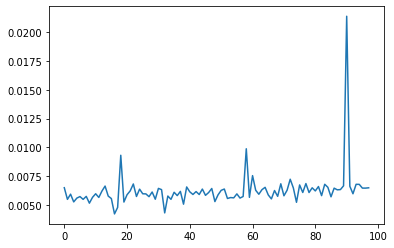

In [64]:
plt.plot(train_losses)

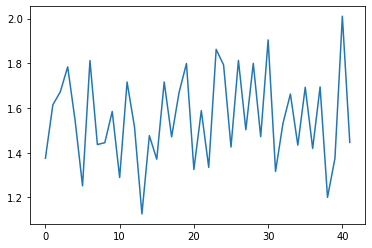

In [62]:
plt.plot(valid_losses)